In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.stochastic_processes.examples import (
    BrownianProcess, BrownianAuxProcess, BrownianBridgeProcess,
    OUProcess, OUAuxProcess, OUBridgeProcess
)
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.gbp import GuidedBridgeProcess
from neuralbridge.networks.score_net import ScoreNet
from neuralbridge.utils.model import NeuralBridge
from neuralbridge.utils.plotting import plot_sample_path

# Guiding Brownian bridge with another Brownian process
We use a Brownian bridge with constant drift as the target bridge, and approximate it by learning from another Brownian bridge without drift, specifically:
$$
\mathrm{d}X_t = \gamma\mathrm{d}t + \sigma\mathrm{d}W_t \\
\mathrm{d}X^{\star}_t = \left\{\gamma + \frac{v - X^{\star}_t - \gamma * (T - t)}{T-t}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t = \left\{\frac{v - X^{\star}_t}{T-t}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
And the auxiliary and guided processes are:
$$
\mathrm{d}\tilde{X}_t = \sigma\mathrm{d}W_t \\
\mathrm{d}X^{\circ}_t = \left\{\gamma + \frac{v - X^{\circ}_t}{T-t}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
Therefore, if the neural guided process is constructed as:
$$
\mathrm{d}X^{\diamond}_t = \left\{\gamma + \frac{v - X^{\circ}_t}{T-t} + \sigma\nu_{\theta}(t, X^{\diamond}_t)\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
We can expect:
$$
\nu_{\theta^*}(t, x) = -\frac{\gamma}{\sigma}
$$

In [14]:
dim = 1
T = 1.0
dt = 1. / 200
dtype = jnp.float32

gamma = 1.0
sigma = 1.0

seed = 42
u = jnp.array([0.0], dtype=dtype)
v = jnp.array([0.0], dtype=dtype)

In [15]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

ori_proc = BrownianProcess(gamma, sigma, T, dim, dtype)
aux_proc = BrownianAuxProcess(0.0, sigma, T, dim, dtype)
bridge_proc = BrownianBridgeProcess(gamma, sigma, score_fn=None, v=v, T=T, dim=dim, dtype=dtype)

guided_bridge_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.eye(dim, dtype=dtype),
    Sigma0=jnp.eye(dim, dtype=dtype) * 1e-10,
    ts=jnp.arange(0, T + dt, dt, dtype=dtype),
    ode_solver_kernel=ode_solver_kernel
)

In [16]:
net = ScoreNet(out_dim=dim, 
              hidden_dims=(32, 64, 32),
              norm="batch",
              t_emb_dim=32,
              t_emb_max_period=50.0,
              t_emb_scaling=200.0)

In [17]:
train_config = {
    "save_name": "brownian_bridge_normalized_ll",
    "seed": seed,
    "learning_rate": 2e-4,
    "batch_size": 128,
    "n_iters": 1000,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 0
}

In [18]:
model = NeuralBridge(guided_bridge_proc, net, train_config)

In [19]:
wiener_proc = WienerProcess(T, dt, dim, dtype, t_scheme)
model.init_path_solver(wiener_proc)
losses = model.train_neural_bridge(u=u, v=v, mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: -0.00268
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/brownian_bridge_normalized_ll/epoch_1


Epoch 2:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: -0.00328
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/brownian_bridge_normalized_ll/epoch_2


Epoch 3:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: -0.00329
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/brownian_bridge_normalized_ll/epoch_3


Epoch 4:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: -0.00325
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/brownian_bridge_normalized_ll/epoch_4


Epoch 5:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: -0.00326
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/brownian_bridge_normalized_ll/epoch_5


Epoch 6:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 6 average loss: -0.00327
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/brownian_bridge_normalized_ll/epoch_6


Epoch 7:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 7 average loss: -0.00328
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/brownian_bridge_normalized_ll/epoch_7


Epoch 8:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 8 average loss: -0.00323
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/brownian_bridge_normalized_ll/epoch_8


Epoch 9:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 9 average loss: -0.00323
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/brownian_bridge_normalized_ll/epoch_9


Epoch 10:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 10 average loss: -0.00328
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/brownian_bridge_normalized_ll/epoch_10


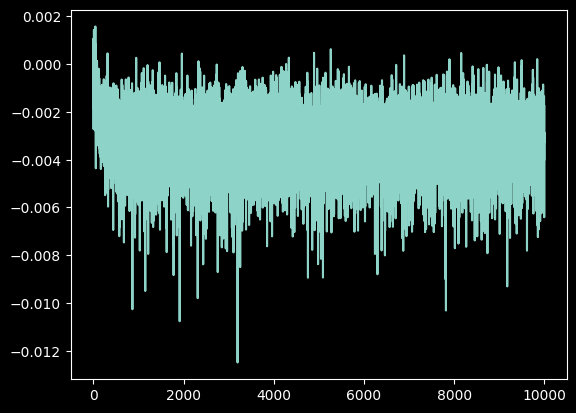

In [20]:
plt.plot(losses)

In [21]:
neural_bridge = model.build_neural_bridge()
# neural_bridge = model.neural_bridge

<Axes: xlabel='$t$', ylabel='$x$'>

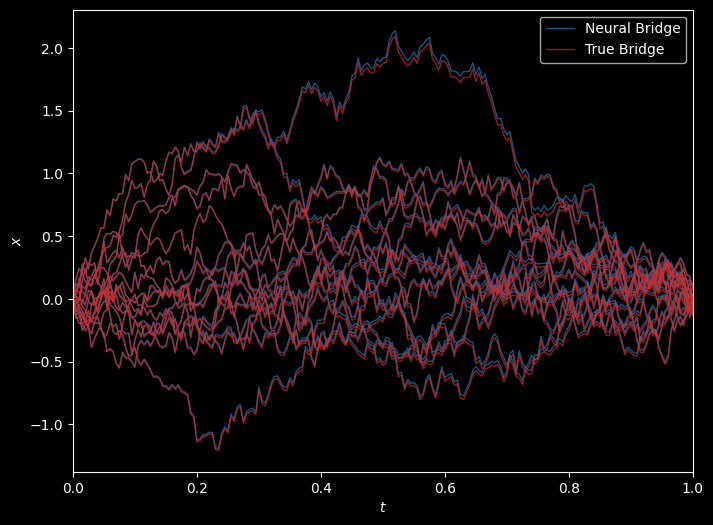

In [22]:
neural_bridge_solver = Euler(neural_bridge, wiener_proc)
bridge_solver = Euler(bridge_proc, wiener_proc)
neural_bridge_path = neural_bridge_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)
bridge_path = bridge_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_sample_path(neural_bridge_path, ax=ax, color="tab:blue", label="Neural Bridge")
plot_sample_path(bridge_path, ax=ax, color="tab:red", label="True Bridge")

# Guiding OU bridge with a Brownian process
We then use a standard Brownian motion as the auxiliary process to approach the Ornstein–Uhlenbeck bridge, specifically:
$$
\mathrm{d}X_t = -\gamma \cdot X_t \mathrm{d}W_t + \sigma \mathrm{d}W_t \\
\mathrm{d}X^{\star}_t = -\gamma\left[\frac{v}{\sinh(-\gamma(T-t))} - \frac{X^{\star}_t}{\tanh(-\gamma(T-t))}\right]\mathrm{d}t + \sigma\mathrm{d}W_t
$$
See _Constraint Ornstein-Uhlenbeck bridges, Alain Mazzolo_ for derived OU bridge. Then we choose a Brownian motion as the auxiliary process:
$$
\mathrm{d}\tilde{X}_t = \sigma \mathrm{d}W_t \\
\mathrm{d}X^{\circ}_t = \left\{-\gamma\cdot X^{\circ}_t + \frac{v-X^{\circ}_t}{T-t}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
Therefore, if the neural guided process is constructed as:
$$
\mathrm{d}X^{\diamond}_t = \left\{-\gamma\cdot X^{\diamond}_t +\frac{v - X^{\diamond}_t}{T-t} + \sigma\nu_{\theta}(t, X^{\diamond}_t)\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
We can expect:
$$
\nu_{\theta^*}(t, x) = \frac{1}{\sigma}\left\{-\gamma\left[\frac{v}{\sinh(-\gamma(T-t))} - \frac{x}{\tanh(-\gamma(T-t))}\right] - \frac{v-x}{T-t} + \gamma\cdot x\right\}
$$

In [23]:
dim = 1
T = 1.0
dt = 1. / 200
dtype = jnp.float32

gamma = 1.0
sigma = 1.0

seed = 42
u = jnp.array([0.0], dtype=dtype)
v  = jnp.array([0.0], dtype=dtype)

In [24]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

ori_proc = OUProcess(gamma, sigma, T, dim, dtype)
aux_proc = OUAuxProcess(0.0, sigma, T, dim, dtype)
bridge_proc = OUBridgeProcess(gamma, sigma, score_fn=None, v=v, T=T, dim=dim, dtype=dtype)

guided_bridge_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.eye(dim, dtype=dtype),
    Sigma0=jnp.eye(dim, dtype=dtype) * 1e-10,
    ts=jnp.arange(0, T + dt, dt, dtype=dtype),
    ode_solver_kernel=ode_solver_kernel
)

In [25]:
net = ScoreNet(out_dim=dim, 
              hidden_dims=(32, 64, 32),
              norm="batch",
              t_emb_dim=32,
              t_emb_max_period=50.0,
              t_emb_scaling=200.0)

In [26]:
train_config = {
    "save_name": "ou_bridge_normalized_ll",
    "seed": seed,
    "learning_rate": 2e-4,
    "batch_size": 128,
    "n_iters": 1000,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 0
}

In [27]:
model = NeuralBridge(guided_bridge_proc, net, train_config)

In [28]:
wiener_proc = WienerProcess(T, dt, dim, dtype, t_scheme)
model.init_path_solver(wiener_proc)
losses = model.train_neural_bridge(u=u, v=v, mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: -0.00026
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/ou_bridge_normalized_ll/epoch_1


Epoch 2:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: -0.00037
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/ou_bridge_normalized_ll/epoch_2


Epoch 3:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: -0.00035
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/ou_bridge_normalized_ll/epoch_3


Epoch 4:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: -0.00036
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/ou_bridge_normalized_ll/epoch_4


Epoch 5:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: -0.00037
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/ou_bridge_normalized_ll/epoch_5


Epoch 6:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 6 average loss: -0.00035
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/ou_bridge_normalized_ll/epoch_6


Epoch 7:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 7 average loss: -0.00037
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/ou_bridge_normalized_ll/epoch_7


Epoch 8:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 8 average loss: -0.00037
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/ou_bridge_normalized_ll/epoch_8


Epoch 9:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 9 average loss: -0.00036
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/ou_bridge_normalized_ll/epoch_9


Epoch 10:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 10 average loss: -0.00037
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/ou_bridge_normalized_ll/epoch_10


In [29]:
neural_bridge = model.build_neural_bridge()

<Axes: xlabel='$t$', ylabel='$x$'>

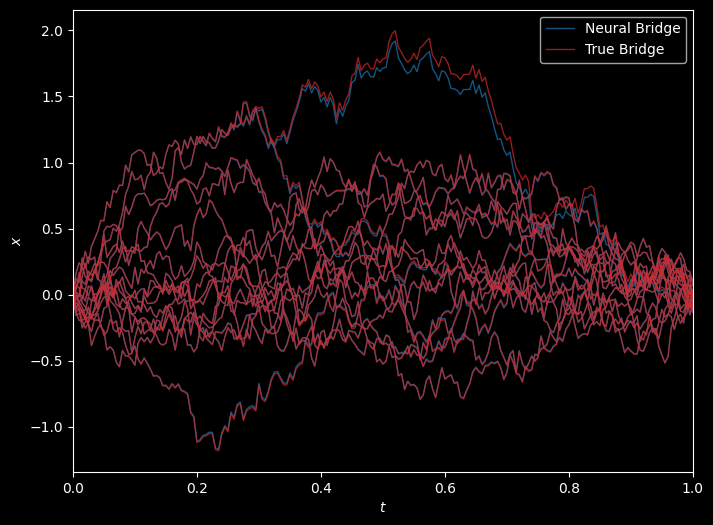

In [30]:
neural_bridge_solver = Euler(neural_bridge, wiener_proc)
bridge_solver = Euler(bridge_proc, wiener_proc)
neural_bridge_path = neural_bridge_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)
bridge_path = bridge_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_sample_path(neural_bridge_path, ax=ax, color="tab:blue", label="Neural Bridge")
plot_sample_path(bridge_path, ax=ax, color="tab:red", label="True Bridge")